In [82]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [41]:
df = pd.read_csv(r"C:\Users\ellah\OneDrive\Data Science Projects\asthma-weather-impact\asthma-ed-visit-rates_2019.csv")

In [42]:
df = df.drop(columns=['LGHC Indicator ID', 'Strata', 'LGHC Target Rate'])

df = df[~df['Age Group'].isin([
    'Under 20',
    'Under 19'
])]

df = df.dropna(subset=['Rate'])

In [43]:
y = df['Rate']
X = df.drop(columns=[
    'Rate',
    'Numerator',
    'LGHC Indicator Name'
])

In [44]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [47]:
param_grid = {
    'model__n_estimators': [400, 500, 600],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'model__min_child_weight': [1, 5, 10],
    'model__min_child_weight': [1, 5, 10]
}

In [48]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state =42))
])

In [49]:
xgb_cv_search = RandomizedSearchCV(
    xgb_model,
    param_distributions = param_grid,
    n_iter = 30,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

In [50]:
xgb_model.fit(X_train, y_train)

xgb_cv_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'model__learning_rate': [0.05, 0.1, ...], 'model__max_depth': [3, 5, ...], 'model__min_child_weight': [1, 5, ...], 'model__n_estimators': [400, 500, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",30
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscros

In [51]:
best_xgb = xgb_cv_search.best_estimator_

In [76]:
y_pred_xgb = xgb_model.predict(X_test)

y_pred_best_xgb = best_xgb.predict(X_test)

In [77]:
baseline_pred = np.full_like(y_test, y_test.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

baseline_pred_xgb = np.full_like(y_test, y_test.mean())
baseline_rmse_xgb = np.sqrt(mean_squared_error(y_test, baseline_pred_xgb))

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

In [78]:
print(f"Baseline RMSE: {baseline_rmse:.2f}")


print(f'R2_xgb: {r2_xgb:.3f}')
print(f'RMSE_xgb: {rmse_xgb:.2f}')

print(f'R2_best_xgb: {r2_best_xgb: .3f}')
print(f'RMSE_best_xgb: {rmse_best_xgb: .2f}')

Baseline RMSE: 65.89
R2_xgb: 0.895
RMSE_xgb: 21.38
R2_best_xgb:  0.925
RMSE_best_xgb:  18.08


In [55]:
xgb_cv_search.best_params_

{'model__n_estimators': 600,
 'model__min_child_weight': 1,
 'model__max_depth': 7,
 'model__learning_rate': 0.1}

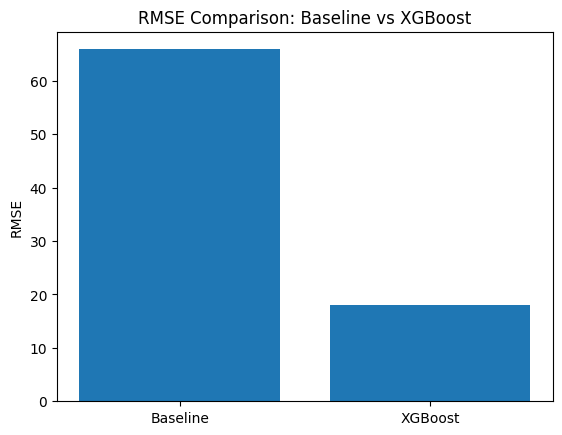

In [60]:
models = ['Baseline', 'XGBoost']
rmse_values = [baseline_rmse, rmse_best_xgb]

plt.figure()
plt.bar(models, rmse_values)
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Baseline vs XGBoost')
plt.show()

XGBoost reduces prediction error by nearly two-thirds compared to the baseline.

In [68]:
best_xgb = xgb_cv_search.best_estimator_

preprocessor = best_xgb.named_steps['preprocessor']
model = best_xgb.named_steps['model']

In [69]:
X_train_transformed = preprocessor.transform(X_train)

In [70]:
feature_names = preprocessor.get_feature_names_out()

In [72]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

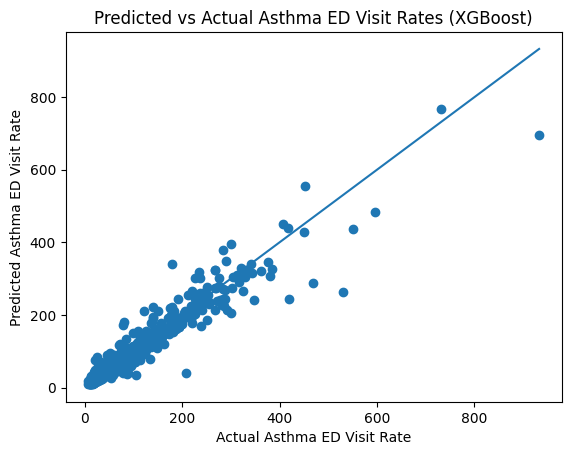

In [80]:
plt.figure()
plt.scatter(y_test, y_pred_best_xgb)
plt.xlabel('Actual Asthma ED Visit Rate')
plt.ylabel('Predicted Asthma ED Visit Rate')
plt.title('Predicted vs Actual Asthma ED Visit Rates (XGBoost)')

# Line of perfect prediction
min_val = min(y_test.min(), y_pred_best_xgb.min())
max_val = max(y_test.max(), y_pred_best_xgb.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

In [84]:
cv_scores = -xgb_cv_search.cv_results_['mean_test_score']
print(f"CV RMSE range: {cv_scores.min():.2f}–{cv_scores.max():.2f}")

CV RMSE range: 25.80–61.61


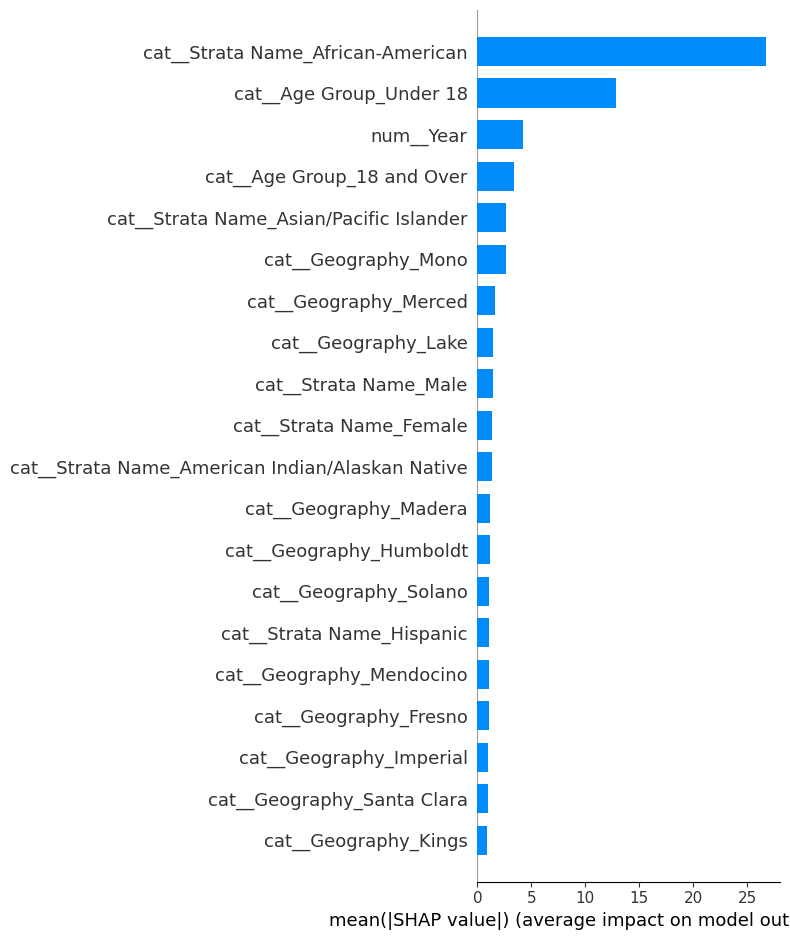

In [74]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)